In [1]:
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio

In [2]:
Path.cwd().parent.resolve()

PosixPath('/home/windact/cloud_detection')

In [3]:
ROOT_DIR = Path.cwd().parent.resolve()
ROOT_DIR

PosixPath('/home/windact/cloud_detection')

In [4]:
DATA_DIR = ROOT_DIR / "data"
DATA_DIR

PosixPath('/home/windact/cloud_detection/data')

In [5]:
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

In [6]:
TRAIN_DATA_PATH= DATA_DIR / "train_data.csv"
VAL_DATA_PATH= DATA_DIR / "val_data.csv"

In [7]:
# Train dataset

In [8]:
file_paths = TRAIN_DATA_PATH

In [9]:
train_dataset = tf.data.TextLineDataset(filenames=file_paths)

In [10]:
list(train_dataset.skip(1).take(5))

[<tf.Tensor: shape=(), dtype=string, numpy=b'adwp;/home/windact/cloud_detection/data/train_features/adwp/B02.tif;/home/windact/cloud_detection/data/train_features/adwp/B03.tif;/home/windact/cloud_detection/data/train_features/adwp/B04.tif;/home/windact/cloud_detection/data/train_features/adwp/B08.tif;/home/windact/cloud_detection/data/train_labels/adwp.tif'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'adwu;/home/windact/cloud_detection/data/train_features/adwu/B02.tif;/home/windact/cloud_detection/data/train_features/adwu/B03.tif;/home/windact/cloud_detection/data/train_features/adwu/B04.tif;/home/windact/cloud_detection/data/train_features/adwu/B08.tif;/home/windact/cloud_detection/data/train_labels/adwu.tif'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'adwz;/home/windact/cloud_detection/data/train_features/adwz/B02.tif;/home/windact/cloud_detection/data/train_features/adwz/B03.tif;/home/windact/cloud_detection/data/train_features/adwz/B04.tif;/home/windact/cloud_detection/data/tr

In [7]:
IMG_HEIGHT = tf.constant(192, dtype=tf.int32)
IMG_WIDTH = tf.constant(192,dtype=tf.int32)
EPOCHS  = 2

@tf.function
def load_image(img_path):
    image = tf.io.read_file(img_path)
    image = tfio.experimental.image.decode_tiff(image)
    
    return image

@tf.function
def parser(row_csv):
    # decoding the csv file
    chip_id,B02_path,B03_path,B04_path,B08_path,label_path = tf.io.decode_csv(records = row_csv, record_defaults = ["chip_id","B02_path","B03_path","B04_path","B08_path","label_path"], field_delim=';')
    
    B02_img = load_image(B02_path)
    # B02_img = B02_img[:,:,0]
    # B02_img = tf.expand_dims(B02_img, axis = -1, name=None)
    
    B03_img = load_image(B03_path)
    # B03_img = B03_img[:,:,0]
    # B03_img = tf.expand_dims(B03_img, axis = -1, name=None)
    
    B04_img = load_image(B04_path)
    # B04_img = B04_img[:,:,0]
    # B04_img = tf.expand_dims(B04_img, axis = -1, name=None)
    
    B08_img = load_image(B08_path)
    # B08_img = B08_img[:,:,0]
    # B08_img = tf.expand_dims(B08_img, axis = -1, name=None)
    
    image = tf.concat([B02_img,B03_img,B04_img,B08_img], axis = -1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32, saturate=False)
    
    label = load_image(label_path)
    # label = label[:,:,0]
    # label = tf.expand_dims(label, axis = -1, name=None)
    
    label = tf.image.convert_image_dtype(label, dtype=tf.float32, saturate=False)
    
    
    return image, label

@tf.function
def img_reshape(img,msk):
    img_o = tf.image.resize(img,(192, 192),preserve_aspect_ratio=False)
    msk_o = tf.image.resize(msk,(192, 192),preserve_aspect_ratio=False)
    
    return img_o,msk_o
    

@tf.function
def rotate_clk_img_and_msk(img, msk):
    angles_tensor = tf.constant([4, 6, 8, 10, 12, 14, 16, 18, 20], dtype=tf.float32)
    angle = tf.random.shuffle(angles_tensor)[0]
    # Image
    img_o = tfa.image.rotate(images = img,angles = angle,interpolation = "nearest",fill_mode = "reflect",fill_value = 0.0)
    # Label
    msk_o = tfa.image.rotate(images = msk,angles = angle,interpolation = "nearest",fill_mode = "reflect",fill_value = 0.0)
    
    return img_o, msk_o

@tf.function
def rotate_cclk_img_and_msk(img, msk):
    angles_tensor = tf.constant([-20, -18, -16, -14, -12, -10, -8, -6, -4],dtype=tf.float32)
    angle = tf.random.shuffle(angles_tensor)[0]
    # Image
    img_o = tfa.image.rotate(images = img,angles = angle,interpolation = "nearest",fill_mode = "reflect",fill_value = 0.0)
    # Label
    msk_o = tfa.image.rotate(images = msk,angles = angle,interpolation = "nearest",fill_mode = "reflect",fill_value = 0.0)
    
    return img_o, msk_o

@tf.function
def flipping_img_and_msk(img, msk):
    img_o = tf.image.flip_left_right(img)
    img_o = tf.image.flip_up_down(img)
    
    msk_o = tf.image.flip_left_right(msk)
    msk_o = tf.image.flip_up_down(msk)
    
    return img_o,msk_o


    
@tf.function
def zoom_img_and_msk(img, msk,height = 512,width = 512):

    zoom_factor_tensor = tf.constant([1.2, 1.5, 1.8, 2, 2.2, 2.5], dtype=tf.float32)  # currently doesn't have zoom out!
    zoom_factor = tf.random.shuffle(zoom_factor_tensor)[0]
    # print("*-*-*-*-*-*")
    # print(img.shape)
    #h,w,c = img.shape
    # h = height
    # w = width
    h = tf.cast(height,dtype= tf.int32)
    w = tf.cast(width,dtype= tf.int32)
    
    # img = tf.cast(img, dtype=tf.float32)
    # msk = tf.cast(msk, dtype=tf.float32)
    

    # width and height of the zoomed image
    zh = tf.math.multiply(zoom_factor, tf.cast(h, dtype=tf.float32))
    zh = tf.cast(zh,dtype= tf.int32)
    
    zw = tf.math.multiply(zoom_factor, tf.cast(w, dtype=tf.float32))
    zw = tf.cast(zw,dtype= tf.int32)
    
    # zh = int(np.round(zoom_factor * h))
    # zw = int(np.round(zoom_factor * w))

    img = tf.image.resize(img,(zh, zw),preserve_aspect_ratio=False)
    msk = tf.image.resize(msk,(zh, zw),preserve_aspect_ratio=False)
    
    region_tensor = tf.constant([0, 1, 2, 3, 4],dtype= tf.float32)
    region = tf.random.shuffle(region_tensor)[0]

    # zooming out
    # tf.print("before zoom")
    # tf.print(img.dtype)
    
    if tf.math.less_equal(zoom_factor, tf.constant(1, dtype= tf.float32)):
        outimg = img
        outmsk = msk
        
        # tf.print("zoom 1")
        # tf.print(img.dtype)

    # zooming in
    # else:
    #     # Initializing
    #     outimg = tf.zeros_like(img, dtype=tf.float32, name=None)
    #     outmsk = tf.zeros_like(msk, dtype=tf.float32, name=None)
        # bounding box of the clipped region within the input array
    elif tf.math.equal(region, tf.constant(0,dtype= tf.float32)):
        outimg = img[0:h, 0:w,:]
        outmsk = msk[0:h, 0:w,:]
        
        # tf.print("zoom 0")
        # tf.print(img.dtype)
        
    elif tf.math.equal(region, tf.constant(1,dtype= tf.float32)):
        outimg = img[0:h, zw - w:zw,:]
        outmsk = msk[0:h, zw - w:zw,:]
        
        # tf.print("zoom 11")
        # tf.print(img.dtype)
        
    elif tf.math.equal(region, tf.constant(2,dtype= tf.float32)):
        outimg = img[zh - h:zh, 0:w,:]
        outmsk = msk[zh - h:zh, 0:w,:]
        
        # tf.print("zoom 2")
        # tf.print(img.dtype)
        
    elif tf.math.equal(region, tf.constant(3,dtype= tf.float32)):
        outimg = img[zh - h:zh, zw - w:zw,:]
        outmsk = msk[zh - h:zh, zw - w:zw,:]
        
        # tf.print("zoom 3")
        # tf.print(img.dtype)
        
    # if tf.math.equal(region, tf.constant(4,dtype= tf.float32)):

    else:
        # tf.print("zoom 4")
        # tf.print(img.dtype)
        
        marh = tf.math.floordiv( h, tf.constant(2))
        marw = tf.math.floordiv( w, tf.constant(2))

        zh_div = tf.math.floordiv( zh, tf.constant(2))
        zw_div = tf.math.floordiv( zw, tf.constant(2))

        zh_div_add = tf.math.add( zh_div, marh)
        zh_div_minus = tf.math.subtract( zh_div, marh)

        zw_div_add = tf.math.add( zw_div, marw)
        zw_div_minus = tf.math.subtract( zw_div, marw)

        outimg = img[zh_div_minus:zw_div_add, zw_div_minus:zw_div_add,:]
        outmsk = msk[zh_div_minus:zw_div_add, zw_div_minus:zw_div_add,:]

        # outimg = img[(zh // 2 - marh):(zh // 2 + marh), (zw // 2 - marw):(zw // 2 + marw),:]
        # outmsk = msk[(zh // 2 - marh):(zh // 2 + marh), (zw // 2 - marw):(zw // 2 + marw),:]

    # to make sure the output is in the same size of the input
    img_o = tf.image.resize(outimg,(h, w),preserve_aspect_ratio=False)
    msk_o = tf.image.resize(outmsk,(h, w),preserve_aspect_ratio=False)
    return img_o, msk_o


@tf.function
def data_augmentation(img, msk):
    
    coin_rotate_clk_img_and_msk = tf.random.uniform(shape = (1,1), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None)
    coin_rotate_cclk_img_and_msk = tf.random.uniform(shape = (1,1), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None)
    coin_flipping_img_and_msk = tf.random.uniform(shape = (1,1), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None)
    coin_zoom_img_and_msk = tf.random.uniform(shape = (1,1), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None)

    # rotate_clk_img_and_msk
    if tf.math.greater_equal(coin_rotate_clk_img_and_msk, tf.constant(0.5)):
        # tf.print(tf.constant("rotate_clk_img_and_msk"))
        # tf.print(coin_rotate_clk_img_and_msk)
        img,msk = rotate_clk_img_and_msk(img, msk)
    
    # rotate_cclk_img_and_msk
    if tf.math.greater_equal(coin_rotate_cclk_img_and_msk, tf.constant(0.5)):
        # tf.print(tf.constant("rotate_cclk_img_and_msk"))
        # tf.print(coin_rotate_cclk_img_and_msk)
        img,msk = rotate_cclk_img_and_msk(img, msk)
        
    # flipping_img_and_msk
    # rotate_cclk_img_and_msk
    if tf.math.greater_equal(coin_flipping_img_and_msk, tf.constant(0.5)):
        # tf.print(tf.constant("flipping_img_and_msk"))
        # tf.print(coin_flipping_img_and_msk)
        img,msk = flipping_img_and_msk(img, msk)
    
    # zoom_img_and_msk
    if tf.math.greater_equal(coin_zoom_img_and_msk, tf.constant(0.5)):
        # tf.print(tf.constant("coin_zoom_img_and_msk"))
        # tf.print(coin_zoom_img_and_msk)
        img,msk = zoom_img_and_msk(img, msk,height = IMG_HEIGHT,width = IMG_WIDTH)
    
    return img,msk

def load_dataset(file_paths, reshape = False,buffer_size = 1000, batch_size = 12,training = True, num_epochs = EPOCHS):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    dataset = tf.data.TextLineDataset(filenames=file_paths)
    dataset = dataset.skip(1).map(parser).cache()
    
    # reshape
    if reshape == True:
        dataset = dataset.map(img_reshape)
    
    dataset = dataset.map(data_augmentation)
    
    if training == True:
        dataset = dataset.shuffle(buffer_size =buffer_size)
        dataset = dataset.repeat(count=num_epochs)
    else:
        dataset = dataset.repeat(count=1)
        
    dataset = dataset.batch(batch_size = batch_size,drop_remainder = False).prefetch(buffer_size=AUTOTUNE)
    
    return dataset
    



In [8]:
from tensorflow.keras import backend as K
from tensorflow import keras

smooth = 0.0000001


def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))


class ADAMLearningRateTracker(keras.callbacks.Callback):
    """It prints out the last used learning rate after each epoch (useful for resuming a training)
    original code: https://github.com/keras-team/keras/issues/7874#issuecomment-329347949
    """

    def __init__(self, end_lr):
        super(ADAMLearningRateTracker, self).__init__()
        self.end_lr = end_lr

    def on_epoch_end(self, epoch, logs={}):  # works only when decay in optimizer is zero
        optimizer = self.model.optimizer
        # t = K.cast(optimizer.iterations, K.floatx()) + 1
        # lr_t = K.eval(optimizer.lr * (K.sqrt(1. - K.pow(optimizer.beta_2, t)) /
        #                               (1. - K.pow(optimizer.beta_1, t))))
        # print('\n***The last Actual Learning rate in this epoch is:', lr_t,'***\n')
        print('\n***The last Basic Learning rate in this epoch is:', K.eval(optimizer.lr), '***\n')
        # stops the training if the basic lr is less than or equal to end_learning_rate
        if K.eval(optimizer.lr) <= self.end_lr:
            print("training is finished")
            self.model.stop_training = True

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization,\
    Activation, Dropout
from tensorflow import  keras

"""
Some parts borrowed from https://www.kaggle.com/cjansen/u-net-in-keras
"""


def bn_relu(input_tensor):
    """It adds a Batch_normalization layer before a Relu
    """
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def contr_arm(input_tensor, filters, kernel_size):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
       TO DO: remove keras.layers.add and replace it with add only
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def imprv_contr_arm(input_tensor, filters, kernel_size ):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = Conv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = Conv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = Conv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    """It is exactly like the identity_block plus a dropout layer. This block only uses in the valley of the UNet
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def conv_block_exp_path3(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    """It is for adding two feed forwards to the output of the two following conv layers in expanding path
    """

    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x


def improve_ff_block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):
    """It improves the skip connection by using previous layers feature maps
       TO DO: shrink all of ff blocks in one function/class
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block2(input_tensor1, input_tensor2, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    x = keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block1(input_tensor1, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=192, input_cols=192, num_of_channels=4, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = imprv_contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block1(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])


In [10]:
tf.config.run_functions_eagerly(False)

In [11]:
train_dataset = load_dataset(file_paths= TRAIN_DATA_PATH, training = True,reshape= True, num_epochs=2)
val_dataset = load_dataset(file_paths= VAL_DATA_PATH, training = False,reshape= True)

In [12]:
import pandas as pd

In [40]:
train = pd.read_csv(TRAIN_DATA_PATH, sep = ";")

In [41]:
train.head()

,chip_id,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
1,adwu,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
2,adwz,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
3,adxp,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
4,aeaj,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...


In [44]:
train_sample = train.sample(n = 100,replace = False, random_state=42)
train_sample = train_sample.reset_index(drop = True)
train_sample.head()

,chip_id,B02_path,B03_path,B04_path,B08_path,label_path
0,xprk,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
1,bhpa,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
2,wjnh,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
3,snse,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
4,hpob,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...


In [45]:
val = pd.read_csv(VAL_DATA_PATH, sep = ";")

In [46]:
val.head()

,chip_id,B02_path,B03_path,B04_path,B08_path,label_path
0,aebi,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
1,aeey,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
2,aegb,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
3,aege,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
4,aejg,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...


In [48]:
val_sample = val.sample(n = 20,replace = False, random_state=42)
val_sample = val_sample.reset_index(drop = True)
val_sample.head()

,chip_id,B02_path,B03_path,B04_path,B08_path,label_path
0,zbly,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
1,yuxu,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
2,qpal,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
3,rxgv,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...
4,pltr,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_featu...,/home/windact/cloud_detection/data/train_label...


In [49]:
val_sample.shape

(20, 6)

In [50]:
train_sample.shape

(100, 6)

In [51]:
DATA_DIR

PosixPath('/home/windact/cloud_detection/data')

In [52]:
train_sample.to_csv(DATA_DIR / "train_sample.csv", sep = ";", header = True, index = False)
val_sample.to_csv(DATA_DIR / "val_sample.csv", sep = ";", header = True, index = False)

In [13]:
TRAIN_SAMPLE_PATH = DATA_DIR / "train_sample.csv"
VAL_SAMPLE_PATH = DATA_DIR / "val_sample.csv"

In [14]:
TRAIN_SAMPLE_PATH

PosixPath('/home/windact/cloud_detection/data/train_sample.csv')

In [15]:
VAL_SAMPLE_PATH

PosixPath('/home/windact/cloud_detection/data/val_sample.csv')

In [16]:
from datetime import datetime

In [17]:
experiment_name = "sample-cloud-net-"+datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_name

'sample-cloud-net-20220114-094658'

In [18]:
MODEL_DIR = ROOT_DIR / "models"
TRAIN_DIR = MODEL_DIR / "train"
TEST_DIR = MODEL_DIR / "test"
EXP_DIR = TRAIN_DIR / experiment_name
ORIGINAL_MODEL_WEIGHT_PATH = (MODEL_DIR / "original_weights") / "Cloud-Net_trained_on_38-Cloud_training_patches.h5"

In [19]:
ORIGINAL_MODEL_WEIGHT_PATH

PosixPath('/home/windact/cloud_detection/models/original_weights/Cloud-Net_trained_on_38-Cloud_training_patches.h5')

In [20]:
ORIGINAL_MODEL_WEIGHT_PATH.exists()

True

In [72]:
help(MODEL_DIR.mkdir)

Help on method mkdir in module pathlib:

mkdir(mode=511, parents=False, exist_ok=False) method of pathlib.PosixPath instance
    Create a new directory at this given path.



In [21]:
folders = [MODEL_DIR,TRAIN_DIR,TEST_DIR,EXP_DIR]
for folder in folders:
    if not folder.exists():
        folder.mkdir(parents = False,exist_ok= True)

In [22]:
import os
import numpy as np
# from utils import ADAMLearningRateTracker
# import cloud_net_model
# from losses import jacc_coef
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import pandas as pd

in_rows = 192
in_cols = 192
num_of_channels = 16
num_of_classes = 4
starting_learning_rate = 1e-4
end_learning_rate = 1e-8
max_num_epochs = 2  # just a huge number. The actual training should not be limited by this value
patience = 15
decay_factor = 0.7
batch_size = 2
# max_bit = 65535  # maximum gray level in landsat 8 images
weights_path = EXP_DIR / "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
train_resume = False

In [28]:
model = model_arch(input_rows=in_rows,
                                   input_cols=in_cols,
                                   num_of_channels=num_of_channels,
                                   num_of_classes=num_of_classes)
model.compile(optimizer=Adam(learning_rate=starting_learning_rate), loss=jacc_coef, metrics=[jacc_coef])

In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 192, 16 0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 192, 192, 16) 2320        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 192, 192, 32) 4640        conv2d_99[0][0]                  
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 192, 192, 32) 128         conv2d_100[0][0]                 
____________________________________________________________________________________________

In [49]:
ORIGINAL_MODEL_WEIGHT_PATH

PosixPath('/home/windact/cloud_detection/models/original_weights/Cloud-Net_trained_on_38-Cloud_training_patches.h5')

In [23]:
sample_train_dataset = load_dataset(file_paths= TRAIN_SAMPLE_PATH, training = True,reshape= True, num_epochs=max_num_epochs, batch_size= batch_size)
sample_val_dataset = load_dataset(file_paths= VAL_SAMPLE_PATH, training = False,reshape= True,batch_size= 3)

In [45]:
def main():
    model = model_arch(input_rows=in_rows,
                                       input_cols=in_cols,
                                       num_of_channels=num_of_channels,
                                       num_of_classes=num_of_classes)
    model.compile(optimizer=Adam(learning_rate=starting_learning_rate), loss=jacc_coef, metrics=[jacc_coef])
    # model.summary()

    model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    lr_reducer = ReduceLROnPlateau(factor=decay_factor, cooldown=0, patience=patience, min_lr=end_learning_rate, verbose=1)
    csv_logger = CSVLogger(EXP_DIR / '_log_1.log')

    if train_resume:
        model.load_weights(ORIGINAL_MODEL_WEIGHT_PATH)
        print("\nTraining resumed...")
    else:
        print("\nTraining started from scratch... ")

    print("Experiment name: ", experiment_name)
    print("Input image size: ", (in_rows, in_cols))
    print("Number of input spectral bands: ", num_of_channels)
    print("Learning rate: ", starting_learning_rate)
    print("# Epochs: ", max_num_epochs)
    print("Batch size: ", batch_size, "\n")
    
    model.fit(sample_train_dataset,validation_data = sample_val_dataset,epochs = max_num_epochs,verbose = 1,
             callbacks=[model_checkpoint, lr_reducer, ADAMLearningRateTracker(end_learning_rate), csv_logger])

    # model.fit(
    #     generator=mybatch_generator_train(list(zip(train_img_split, train_msk_split)), in_rows, in_cols, batch_sz, max_bit),
    #     steps_per_epoch=np.ceil(len(train_img_split) / batch_sz), epochs=max_num_epochs, verbose=1,
    #     validation_data=mybatch_generator_validation(list(zip(val_img_split, val_msk_split)), in_rows, in_cols, batch_sz, max_bit),
    #     validation_steps=np.ceil(len(val_img_split) / batch_sz),
    #     callbacks=[model_checkpoint, lr_reducer, ADAMLearningRateTracker(end_learning_rate), csv_logger])

In [46]:
main()


Training started from scratch... 
Experiment name:  sample-cloud-net-20220113-224917
Input image size:  (192, 192)
Number of input spectral bands:  16
Learning rate:  0.0001
# Epochs:  2
Batch size:  2 

Epoch 1/2
100/100 [==============================] - 427s 4s/step - loss: 0.2159 - jacc_coef: 0.2159 - val_loss: 0.0271 - val_jacc_coef: 0.0273


/home/windact/anaconda3/envs/cloudenv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



***The last Basic Learning rate in this epoch is: 1e-04 ***

Epoch 2/2
100/100 [==============================] - 1220s 12s/step - loss: 0.0069 - jacc_coef: 0.0069 - val_loss: 0.0082 - val_jacc_coef: 0.0084

***The last Basic Learning rate in this epoch is: 1e-04 ***



In [ ]:
!wget http://vault.sfu.ca/index.php/s/2Xk6ZRbwfnjrOtu/download

--2022-01-13 20:28:47--  http://vault.sfu.ca/index.php/s/2Xk6ZRbwfnjrOtu/download
Resolving vault.sfu.ca (vault.sfu.ca)... 142.58.225.42
Connecting to vault.sfu.ca (vault.sfu.ca)|142.58.225.42|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://vault.sfu.ca/index.php/s/2Xk6ZRbwfnjrOtu/download [following]
--2022-01-13 20:28:48--  https://vault.sfu.ca/index.php/s/2Xk6ZRbwfnjrOtu/download
Connecting to vault.sfu.ca (vault.sfu.ca)|142.58.225.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438019528 (418M) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>] 417.73M  4.89MB/s    in 2m 25s  

2022-01-13 20:31:14 (2.88 MB/s) - ‘download’ saved [438019528/438019528]



In [24]:
a = list(sample_train_dataset.take(5))

In [25]:
len(a)

5

In [26]:
len(a[0])

2

In [27]:
a[0][0].shape

TensorShape([2, 192, 192, 16])

In [28]:
import matplotlib.pyplot as plt

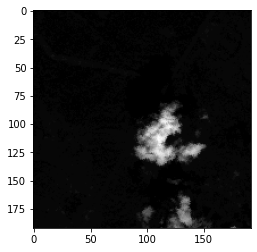

In [29]:
plt.imshow(a[0][0][0,:,:,0], cmap = "gray")

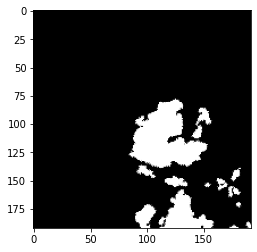

In [30]:
plt.imshow(a[0][1][0,:,:,0], cmap = "gray")

In [30]:
a[0][1].shape

TensorShape([12, 192, 192, 4])

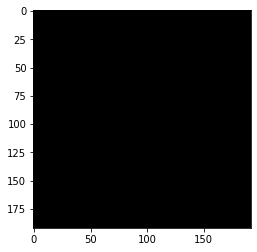

In [33]:
plt.imshow(a[0][0][0,:,:,3], cmap = "gray")

In [84]:
tf.math.equal(tf.constant(True),tf.constant(True))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [12]:
tf.config.run_functions_eagerly(False)
dataset = train_dataset.skip(1).map(parser).map(data_augmentation)

In [38]:
tf.compat.v1.reset_default_graph()

tf.config.run_functions_eagerly(False)
dataset = train_dataset.skip(1).map(parser).map(data_augmentation)

writer = tf.summary.FileWriter('./graphs',tf.compat.v1.get_default_graph())

Help on function reset_default_graph in module tensorflow.python.framework.ops:

reset_default_graph()
    Clears the default graph stack and resets the global default graph.
    
    NOTE: The default graph is a property of the current thread. This
    function applies only to the current thread.  Calling this function while
    a `tf.compat.v1.Session` or `tf.compat.v1.InteractiveSession` is active will
    result in undefined
    behavior. Using any previously created `tf.Operation` or `tf.Tensor` objects
    after calling this function will result in undefined behavior.
    Raises:
      AssertionError: If this function is called within a nested graph.



In [41]:
from datetime import datetime

In [51]:
f,fl = data_augmentation(image_og,label_og)

rotate_clk_img_and_msk
[[0.79082644]]
rotate_cclk_img_and_msk
[[0.985974431]]
coin_zoom_img_and_msk
[[0.517354]]


In [68]:
# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)


# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.config.run_functions_eagerly(True)
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
f,fl = data_augmentation(image_og,label_og)
with writer.as_default():
    tf.summary.trace_export(
      name="dataset_comp",
      step=0,
      profiler_outdir=logdir)

flipping_img_and_msk
[[0.819530487]]
coin_zoom_img_and_msk
[[0.813460946]]


In [69]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [70]:
%reload_ext tensorboard

In [76]:
%tensorboard --logdir logs/func

In [62]:
help(tf.summary.trace_on)

Help on function trace_on in module tensorflow.python.ops.summary_ops_v2:

trace_on(graph=True, profiler=False)
    Starts a trace to record computation graphs and profiling information.
    
    Must be invoked in eager mode.
    
    When enabled, TensorFlow runtime will collection information that can later be
    exported and consumed by TensorBoard. The trace is activated across the entire
    TensorFlow runtime and affects all threads of execution.
    
    To stop the trace and export the collected information, use
    `tf.summary.trace_export`. To stop the trace without exporting, use
    `tf.summary.trace_off`.
    
    Args:
      graph: If True, enables collection of executed graphs. It includes ones from
          tf.function invocation and ones from the legacy graph mode. The default
          is True.
      profiler: If True, enables the advanced profiler. Enabling profiler
          implicitly enables the graph collection. The profiler may incur a high
          memory o

In [77]:
help(dataset.map)

Help on method map in module tensorflow.python.data.ops.dataset_ops:

map(map_func, num_parallel_calls=None, deterministic=None) method of tensorflow.python.data.ops.dataset_ops.MapDataset instance
    Maps `map_func` across the elements of this dataset.
    
    This transformation applies `map_func` to each element of this dataset, and
    returns a new dataset containing the transformed elements, in the same
    order as they appeared in the input. `map_func` can be used to change both
    the values and the structure of a dataset's elements. Supported structure
    constructs are documented
    [here](https://www.tensorflow.org/guide/data#dataset_structure).
    
    For example, `map` can be used for adding 1 to each element, or projecting a
    subset of element components.
    
    >>> dataset = Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
    >>> dataset = dataset.map(lambda x: x + 1)
    >>> list(dataset.as_numpy_iterator())
    [2, 3, 4, 5, 6]
    
    The input signature of 

In [75]:
# The function to be traced.
@tf.function
def my_func(x, y):
  # A simple hand-rolled layer.
  return tf.nn.relu(tf.matmul(x, y))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

In [33]:
input_shape = (512, 512, 4)

In [31]:
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
from tensorflow.keras import Sequential

In [34]:
model = Sequential()

model.add(Conv2D(filters = 32,input_shape = input_shape, kernel_size = (3,3),activation='relu', padding='same'))
model.add(Conv2D(filters = 1,kernel_size = (1,1),activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 1)       33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [13]:
outputs = list(dataset.take(50))

flipping_img_and_msk
[[0.769589543]]
coin_zoom_img_and_msk
[[0.879184723]]
before zoom
tf.float32
zoom 2
tf.float32
rotate_clk_img_and_msk
[[0.710716128]]
flipping_img_and_msk
[[0.506204]]
flipping_img_and_msk
[[0.961349845]]
rotate_clk_img_and_msk
[[0.522604108]]
rotate_cclk_img_and_msk
[[0.870754838]]
rotate_clk_img_and_msk
[[0.727573276]]
coin_zoom_img_and_msk
[[0.563992739]]
before zoom
tf.float32
zoom 3
tf.float32
rotate_cclk_img_and_msk
[[0.60824132]]
coin_zoom_img_and_msk
[[0.611725807]]
before zoom
tf.float32
zoom 2
tf.float32
rotate_clk_img_and_msk
[[0.695493698]]
flipping_img_and_msk
[[0.677584648]]
rotate_cclk_img_and_msk
[[0.950132608]]
flipping_img_and_msk
[[0.638463259]]
rotate_clk_img_and_msk
[[0.961683393]]
rotate_clk_img_and_msk
[[0.550060153]]
flipping_img_and_msk
[[0.7014606]]
rotate_clk_img_and_msk
[[0.630058527]]
flipping_img_and_msk
[[0.669974208]]
coin_zoom_img_and_msk
[[0.535625458]]
before zoom
tf.float32
zoom 4
tf.float32
rotate_cclk_img_and_msk
[[0.784454584]

In [153]:
zlike = tf.zeros_like(
    image, dtype=None, name=None
)

In [173]:
tf.cast(18.5,dtype = tf.int32)

<tf.Tensor: shape=(), dtype=int32, numpy=18>

In [157]:
zlike.dtype

tf.uint8

In [158]:
image.dtype

tf.uint8

In [154]:
image.shape

TensorShape([512, 512, 16])

In [156]:
zlike.shape

TensorShape([512, 512, 16])

In [67]:
tf.config.run_functions_eagerly(True)
dataset = train_dataset.skip(1).map(parser)

In [68]:
dataset = train_dataset.skip(1).map(parser)

In [69]:
f = list(dataset.take(5))

In [59]:
len(f)

5

In [60]:
len(f[0])

2

In [61]:
f[0][0].shape

TensorShape([512, 512, 16])

In [62]:
type(f[0][0])

tensorflow.python.framework.ops.EagerTensor

In [52]:
import matplotlib.pyplot as plt

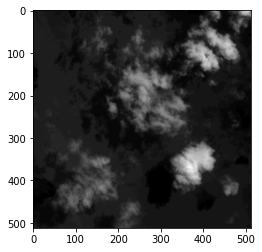

In [53]:
plt.imshow(f[0][0][:,:,0].numpy(), cmap= "gray")

In [54]:
f[0][1].shape

TensorShape([512, 512, 4])

In [55]:
type(f[0][1])

tensorflow.python.framework.ops.EagerTensor

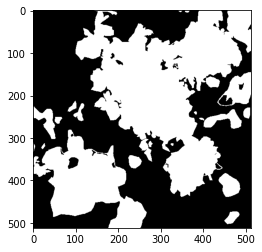

In [56]:
plt.imshow(f[0][1][:,:,0], cmap = "gray")

In [70]:
image, label = f[0]

In [71]:
image.shape

TensorShape([512, 512, 16])

In [72]:
label.shape

TensorShape([512, 512, 4])

In [ ]:
tf.config.run_functions_eagerly(True)


In [86]:
tf.config.run_functions_eagerly(False)
ir,lr = rotate_clk_img_and_msk(image, label)

In [74]:
image.dtype

tf.uint8

In [76]:
label.dtype

tf.uint8

In [77]:
tf.cast(image, dtype=tf.float32)

<tf.Tensor: shape=(512, 512, 16), dtype=float32, numpy=
array([[[  5.,   5.,   5., ...,   3.,   3., 255.],
        [  5.,   5.,   5., ...,   3.,   3., 255.],
        [  6.,   6.,   6., ...,   3.,   3., 255.],
        ...,
        [ 27.,  27.,  27., ...,  24.,  24., 255.],
        [ 24.,  24.,  24., ...,  22.,  22., 255.],
        [ 24.,  24.,  24., ...,  22.,  22., 255.]],

       [[  6.,   6.,   6., ...,   3.,   3., 255.],
        [  5.,   5.,   5., ...,   3.,   3., 255.],
        [  6.,   6.,   6., ...,   3.,   3., 255.],
        ...,
        [ 26.,  26.,  26., ...,  23.,  23., 255.],
        [ 24.,  24.,  24., ...,  22.,  22., 255.],
        [ 24.,  24.,  24., ...,  21.,  21., 255.]],

       [[  6.,   6.,   6., ...,   3.,   3., 255.],
        [  5.,   5.,   5., ...,   3.,   3., 255.],
        [  6.,   6.,   6., ...,   3.,   3., 255.],
        ...,
        [ 24.,  24.,  24., ...,  21.,  21., 255.],
        [ 23.,  23.,  23., ...,  20.,  20., 255.],
        [ 23.,  23.,  23., ...,  2

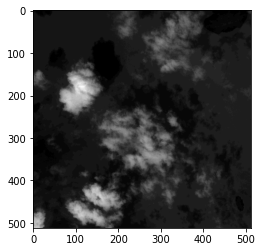

In [82]:
plt.imshow(ir[:,:,0], cmap = "gray")

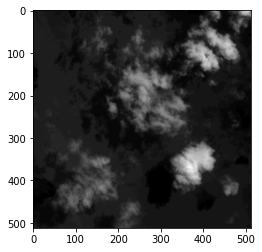

In [84]:
plt.imshow(image[:,:,0], cmap = "gray")

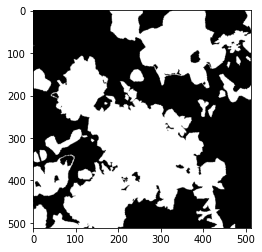

In [83]:
plt.imshow(lr[:,:,0], cmap = "gray")

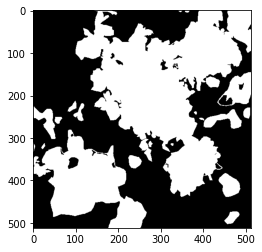

In [85]:
plt.imshow(label[:,:,0], cmap = "gray")

In [18]:
tf.config.run_functions_eagerly(False)
dataset = train_dataset.skip(1).map(parser).map(data_augmentation)

In [14]:
outputs = list(dataset.take(5))

flipping_img_and_msk
[[0.750233889]]
rotate_cclk_img_and_msk
[[0.854620934]]
flipping_img_and_msk
[[0.852463603]]
coin_zoom_img_and_msk
[[0.652289033]]
before zoom
tf.float32
zoom 3
tf.float32
rotate_clk_img_and_msk
[[0.768417239]]
rotate_cclk_img_and_msk
[[0.887747526]]
coin_zoom_img_and_msk
[[0.883666873]]
before zoom
tf.float32
zoom 3
tf.float32
rotate_cclk_img_and_msk
[[0.995643]]
rotate_clk_img_and_msk
[[0.864920259]]
rotate_cclk_img_and_msk
[[0.829363227]]
coin_zoom_img_and_msk
[[0.513843775]]
before zoom
tf.float32
zoom 3
tf.float32


In [15]:
len(outputs)

5

In [20]:
import matplotlib.pyplot as plt

In [16]:
image,label = outputs[0]

In [17]:
image.shape

TensorShape([512, 512, 16])

In [18]:
label.shape

TensorShape([512, 512, 4])

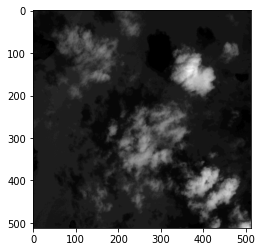

In [21]:
plt.imshow(image[:,:,0], cmap = "gray")

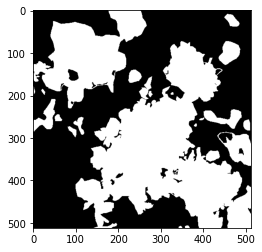

In [22]:
plt.imshow(label[:,:,0], cmap = "gray")

In [23]:
dataset_og = train_dataset.skip(1).map(parser)

In [24]:
outputs_og = list(dataset_og.take(5))

In [25]:
image_og,label_og = outputs_og[0]

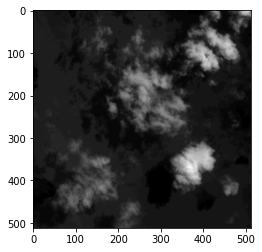

In [26]:
plt.imshow(image_og[:,:,0], cmap = "gray")

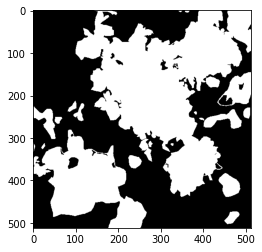

In [27]:
plt.imshow(label_og[:,:,0], cmap = "gray")

In [106]:
coin = tf.random.uniform(
    shape = (1,1), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None
)
coin

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.31031406]], dtype=float32)>

In [107]:
tf.math.greater_equal(coin, tf.constant(0.5))

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[False]])>

In [205]:
tf.config.run_functions_eagerly(False)
iz,lz = zoom_img_and_msk(image,label,512,512)

In [206]:
iz.shape

TensorShape([512, 512, 16])

In [207]:
lz.shape

TensorShape([512, 512, 4])

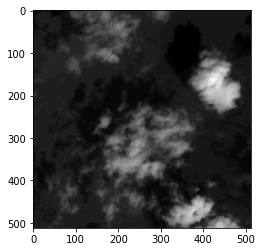

In [208]:
plt.imshow(iz[:,:,0], cmap = "gray")

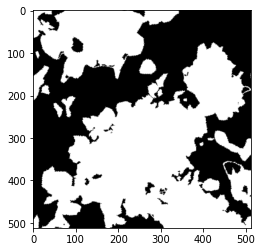

In [209]:
plt.imshow(lz[:,:,0], cmap = "gray")

In [105]:
t  = tf.data.TextLineDataset(TRAIN_DATA_PATH).skip(1).map(parser)

In [106]:
a = list(t.take(5))

In [107]:
a[0][1].shape

TensorShape([512, 512, 1])

In [98]:
tf.expand_dims(
    a[0][0], axis = -1, name=None
).shape

TensorShape([512, 2048, 1])